## Определение тональности текстов отзывов на сайте [YELP](https://www.yelp.com/dataset) одномерной сверточной нейросетью

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dl-urfu-yelp/sample_submission.csv
/kaggle/input/dl-urfu-yelp/train.csv
/kaggle/input/dl-urfu-yelp/test.csv
/kaggle/input/dl-urfu-yelp/train_label.csv


Загружаем данные

In [3]:
KAGGLE_PATH = '/kaggle/input/dl-urfu-yelp/'
x_train = pd.read_csv(KAGGLE_PATH + 'train.csv')
y_train = pd.read_csv(KAGGLE_PATH + 'train_label.csv', index_col=0)
x_test = pd.read_csv(KAGGLE_PATH + 'test.csv')
x_train.shape, y_train.shape, x_test.shape, 

((560000, 1), (560000, 1), (4000, 1))

## Подготовка данных для обучения

### Токенизация текста

In [4]:
# извлекаем столбец с текстом
x_train = x_train.Review
x_test = x_test.Review

In [5]:
# указываем длину словаря, который мы будем использовать
num_words = 10000
# указываем длину последовательности, к которой приведем все тексты
max_review_len = 450
# создаем и обучаем токенизатор на тернировочных данных
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)
# применяем токенизатор к тренировочным и тестовым данным
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
# приводим все вектора текстов к общей длине
x_train = pad_sequences(x_train, maxlen=max_review_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_review_len, padding='post')

## Создание нейронной сети

In [14]:
model = Sequential()
model.add(Embedding(num_words, 128, input_length=max_review_len))
model.add(Conv1D(125, 9, padding='valid', activation='relu'))
model.add(Conv1D(125, 9, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(250, 9, padding='valid', activation='relu'))
model.add(Conv1D(250, 9, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(500, 9, padding='valid', activation='relu'))
model.add(Conv1D(500, 9, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile(optimizer="adam", 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.00001,
                              verbose=1)

In [17]:
save_best = ModelCheckpoint(filepath="best_weights.hdf5",
                            monitor="val_accuracy",
                            save_best_only=True,
                            mode="auto",
                            verbose=1)

## Обучаем нейронную сеть

In [18]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=15,
                    batch_size=1024,
                    validation_split=0.1,
                    verbose=2,
                    callbacks=[save_best, reduce_lr],
                    )

Epoch 1/15
493/493 - 403s - loss: 0.2304 - accuracy: 0.9037 - val_loss: 0.1421 - val_accuracy: 0.9492

Epoch 00001: val_accuracy improved from -inf to 0.94921, saving model to best_weights.hdf5
Epoch 2/15
493/493 - 395s - loss: 0.1338 - accuracy: 0.9527 - val_loss: 0.1040 - val_accuracy: 0.9608

Epoch 00002: val_accuracy improved from 0.94921 to 0.96079, saving model to best_weights.hdf5
Epoch 3/15
493/493 - 394s - loss: 0.1060 - accuracy: 0.9629 - val_loss: 0.1059 - val_accuracy: 0.9610

Epoch 00003: val_accuracy improved from 0.96079 to 0.96100, saving model to best_weights.hdf5
Epoch 4/15
493/493 - 393s - loss: 0.0810 - accuracy: 0.9718 - val_loss: 0.1076 - val_accuracy: 0.9620

Epoch 00004: val_accuracy improved from 0.96100 to 0.96196, saving model to best_weights.hdf5
Epoch 5/15
493/493 - 393s - loss: 0.0588 - accuracy: 0.9801 - val_loss: 0.1425 - val_accuracy: 0.9541

Epoch 00005: val_accuracy did not improve from 0.96196
Epoch 6/15
493/493 - 393s - loss: 0.0415 - accuracy: 0.98

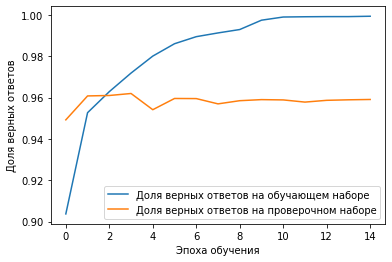

In [19]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Готовим данные для LeaderBoard

In [20]:
model.load_weights("best_weights.hdf5")

In [21]:
sample_submission = pd.read_csv(KAGGLE_PATH + 'sample_submission.csv', index_col='id')
sample_submission.label = model.predict_classes(x_test)
sample_submission.to_csv("submission.csv")

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
